In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
from sd3_pipeline import SD3CNPipeline
from sd3 import SD3CNModel, get_sigmas
from diffusers import AutoencoderKL, FlowMatchEulerDiscreteScheduler
import torch
import numpy as np
from controlnext import ControlNeXtModel
import copy

In [29]:
from text_embed import encode_prompt, get_precomputed_tensors
from diffusers.training_utils import compute_density_for_timestep_sampling, compute_loss_weighting_for_sd3


In [4]:
device = 'cuda:0'

In [5]:
transformer = SD3CNModel.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers", 
    subfolder="transformer", 
    # torch_dtype=torch.float16,
).to(device)

In [6]:
vae = AutoencoderKL.from_pretrained(
            "stabilityai/stable-diffusion-3-medium",
            subfolder="vae",
            revision="refs/pr/26").to(device)

In [20]:
scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers", subfolder="scheduler"
)

In [21]:
scheduler_copy = copy.deepcopy(scheduler)

In [40]:
tensor_list = get_precomputed_tensors(device=device)
        
pixel_list = [x['img'] for x in tensor_list]
hint_list = [x['hint'] for x in tensor_list]
prompt_embed_list = [x['prompt_embeds'] for x in tensor_list]
pooled_prompt_embed_list = [x['pooled_prompt_embeds'] for x in tensor_list]

index = 0
pixel_values = pixel_list[index].to(device)
hint_values = hint_list[index].to(device)
prompt_embeds = prompt_embed_list[index].to(device)
pooled_prompt_embeds = pooled_prompt_embed_list[index].to(device)
print(tensor_list[index]['prompt'])



pale golden rod circle with old lace background


In [95]:
resize = torchvision.transforms.Resize((1024,1024))
pixel_values = resize(pixel_values)
hint_values = resize(hint_values)

In [97]:
hint_values.shape

torch.Size([1, 3, 1024, 1024])

In [101]:
import matplotlib.pyplot as plt

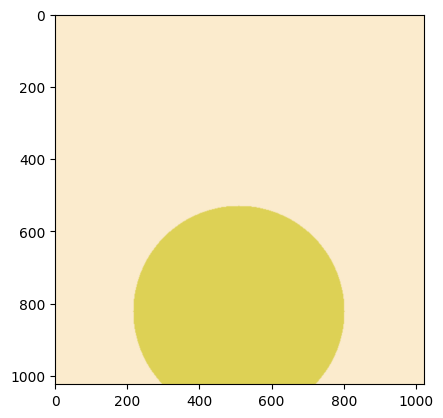

In [104]:
plt.imshow(pixel_values.squeeze(0).permute(1, 2, 0).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


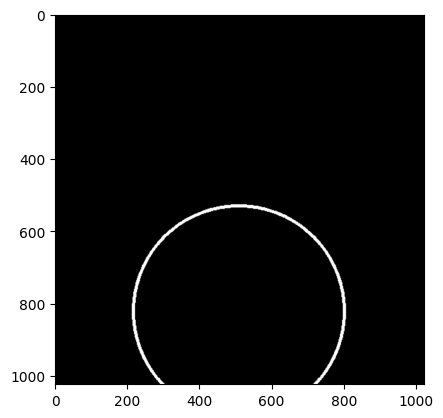

In [103]:
plt.imshow(hint_values.squeeze(0).permute(1, 2, 0).cpu().numpy())

In [27]:
weight_dtype = torch.float32
logit_mean = 0.0
logit_std = 1.0
mode_scale = 1.29
weighting_scheme = "logit_normal"
device = 'cuda:0'

scheduler_type = "constant"
lr_warmup_steps = 500
max_train_steps = 1000
lr_num_cycles = 1
lr_power = 1.0

learning_rate = 1e-4
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_weight_decay = 1e-4
adam_epsilon = 1e-8

In [51]:
pixel_values.shape

torch.Size([1, 3, 512, 512])

In [55]:
from diffusers.utils.torch_utils import randn_tensor

In [61]:
t1 = randn_tensor((1, 3, 512, 512)).to(device)
t2 = randn_tensor((1, 3, 128, 128)).to(device)

In [ ]:
resize = torchvision.transforms.Resize((1024,1024))
t3 = resize(t1)

In [70]:
512/64

8.0

In [85]:
res1 = vae.encode(t1)
res2 = vae.encode(t2)
res3 = vae.encode(t3)

In [87]:
print(res1.latent_dist.sample().shape)
print(res2.latent_dist.sample().shape)
print(res3.latent_dist.sample().shape)

torch.Size([1, 16, 64, 64])
torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 128, 128])


In [76]:
import torchvision

In [69]:
print(res1.latent_dist.sample().shape)
print(res2.latent_dist.sample().shape)

torch.Size([1, 16, 64, 64])
torch.Size([1, 16, 16, 16])


In [89]:
import torch.nn as nn

In [93]:
inner_dim = 1536
control_projection = nn.Sequential(
    nn.Linear(inner_dim, inner_dim),
    nn.ReLU(),
    nn.Linear(inner_dim, 4096),
    nn.LayerNorm(inner_dim)  # Apply LayerNorm after transformations
)

In [ ]:
tt = randn_tensor((1, 3, 512, 512)).to(device)

In [94]:
control_next = ControlNeXtModel().to(device)

In [105]:
control_hidden_states = control_next(hint_values, timesteps)['output']

/home/sj/diffusers/src/diffusers/models/downsampling.py:135: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)


In [106]:
control_hidden_states.shape

torch.Size([1, 320, 128, 128])

In [110]:
320*128*128/154*4096

139446990.12987012

In [108]:
320*128*128

5242880

In [111]:
import torch
import torch.nn.functional as F

# Original tensor
x = torch.randn(1, 320, 128, 128)

# Step 1: Downsample spatial dimensions to reduce `[128, 128]` to something smaller
# Let's try downsampling to `[64, 64]` as an intermediate step
x_downsampled = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)

# Step 2: Reduce the channels from `320` to `154` by applying a linear layer
# Reshape to `[1, 320, 64 * 64]`, then apply a linear layer
x_downsampled = x_downsampled.view(1, 320, -1)  # Shape `[1, 320, 4096]`

# Apply a linear layer to reduce channels
linear = torch.nn.Linear(320, 154)
x_downsampled = linear(x_downsampled.permute(0, 2, 1))  # Shape `[1, 4096, 154]`

# Step 3: Reshape to desired shape `[1, 154, 4096]`
x_final = x_downsampled.permute(0, 2, 1)  # Shape `[1, 154, 4096]`

print(x_final.shape)  # Should print torch.Size([1, 154, 4096])


torch.Size([1, 154, 4096])


In [107]:
control_hidden_states.view(1, 154, 4096)

RuntimeError: shape '[1, 154, 4096]' is invalid for input of size 5242880

In [ ]:
control_hidden_states.

In [ ]:
control_projection(

In [ ]:
torch.Size([1, 154, 4096])

In [30]:
model_input = vae.encode(pixel_values).latent_dist.sample()
model_input = (model_input - vae.config.shift_factor) * vae.config.scaling_factor
model_input = model_input.to(dtype=weight_dtype)



/home/sj/diffusers/src/diffusers/models/downsampling.py:135: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)


In [92]:
control_hidden_states.shape

torch.Size([1, 1024, 1536])

In [43]:
3*512*512

786432

In [44]:
16*64*64

65536

In [42]:
pixel_values.shape

torch.Size([1, 3, 512, 512])

In [41]:
model_input.shape

torch.Size([1, 16, 64, 64])

In [ ]:
noise = torch.randn_like(model_input)
bsz = model_input.shape[0]
# Sample a random timestep for each image
# for weighting schemes where we sample timesteps non-uniformly
u = compute_density_for_timestep_sampling(
    weighting_scheme=weighting_scheme,
    batch_size=bsz,
    logit_mean=logit_mean,
    logit_std=logit_std,
    mode_scale=mode_scale,
)


indices = (u * scheduler_copy.config.num_train_timesteps).long()
timesteps = scheduler_copy.timesteps[indices].to(device=model_input.device)
control_hidden_states = control_next(hint_values, timesteps)['output']

In [48]:
sigmas = get_sigmas(timesteps, scheduler_copy, n_dim=model_input.ndim, dtype=model_input.dtype, device=model_input.device)
noisy_model_input = (1.0 - sigmas) * model_input + sigmas * noise

In [49]:
noisy_model_input.shape

torch.Size([1, 16, 64, 64])

In [50]:
2 ** (len(vae.config.block_out_channels) - 1)

8

In [31]:
control_hidden_states.shape

torch.Size([1, 1024, 1536])

In [9]:
pipe = SD3CNPipeline(transformer, scheduler, vae, device)

8


In [38]:
control_hidden_states.shape

torch.Size([1, 1024, 1536])

In [39]:
int(8) // 1

8

In [37]:
res = pipe(prompt_embeds=prompt_embeds,
           pooled_prompt_embeds=pooled_prompt_embeds,
           # control_hidden_states=None,
           control_hidden_states=control_hidden_states,
           index_block_location=0,
           guidance_scale=0.5)
image = res.images[0]

  0%|          | 0/28 [00:00<?, ?it/s]

Hidden states shape: torch.Size([1, 16, 128, 128])
Encoder hidden states shape: torch.Size([1, 154, 4096])
Pooled projections shape: torch.Size([1, 2048])
Timestep shape: torch.Size([1])
Control hidden states shape: torch.Size([1, 1024, 1536])
Index block location: 0


RuntimeError: The size of tensor a (4096) must match the size of tensor b (1024) at non-singleton dimension 1

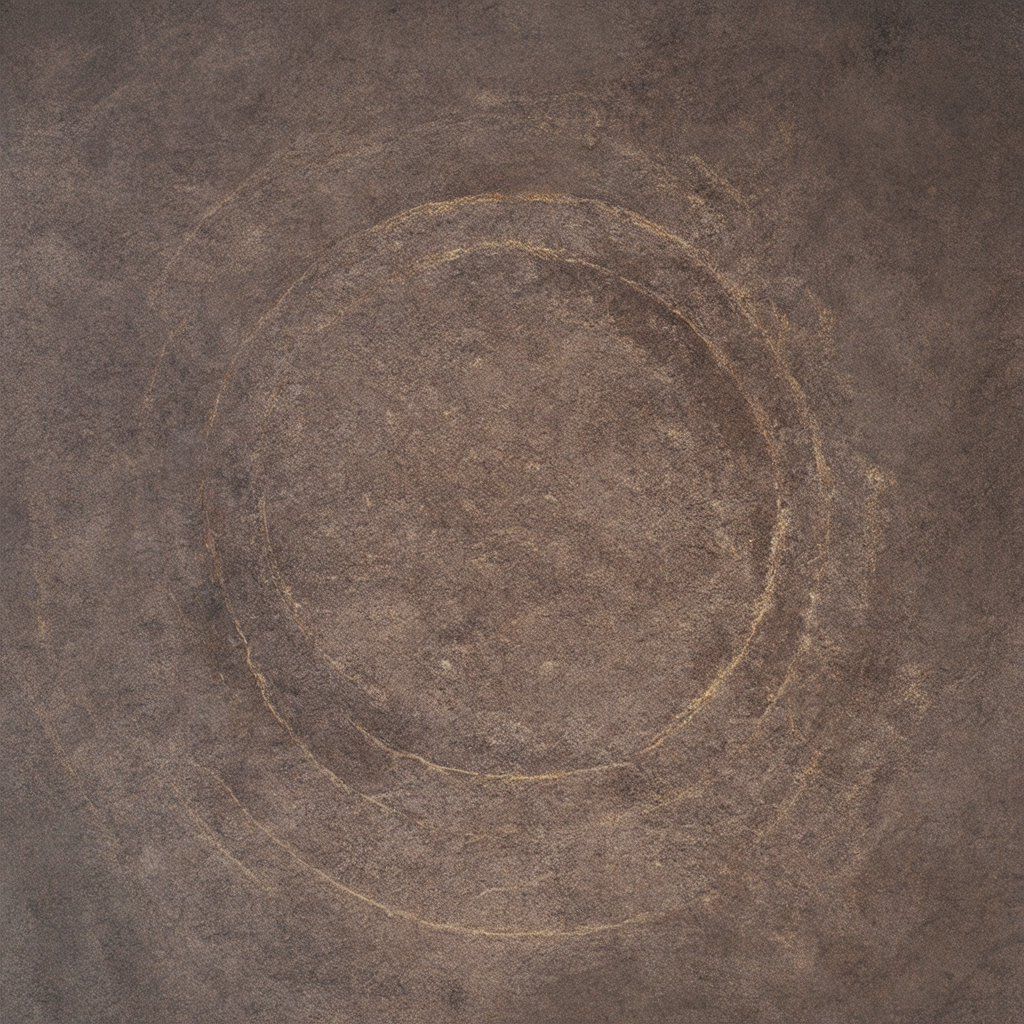

In [36]:
image

In [26]:
np.asarray(image).shape

(1024, 1024, 3)

In [21]:
image.shape

AttributeError: 'Image' object has no attribute 'shape'